<a href="https://colab.research.google.com/github/taeyoonnoh/Kaggle-Competition/blob/main/Iceberg_Classifier_Challenge/My_Trial_Statoil_C_CORE_Iceberg_Classifier_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install -q kaggle

# from google.colab import files

# files.upload()

# ! mkdir ~/.kaggle

# ! cp kaggle.json ~/.kaggle/

# ! chmod 600 ~/.kaggle/kaggle.json


In [2]:
# !kaggle competitions download -c statoil-iceberg-classifier-challenge

In [3]:
# !7z e train.json.7z
# !7z e test.json.7z
# !7z e sample_submission.csv.7z

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

#plt.rcParams['figure.figsize'] = 12, 8
# %matplotlib inline

#Take a look at a iceberg
import plotly.offline as py
from plotly import tools
import plotly.graph_objects as go

#Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

# py.init_notebook_mode(connected=True) # plotly 를 jupyter notebook 에 사용하려면 이 커맨드를 입력해야 합니다.

# Data 

In [5]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

In [6]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [7]:
# check inc_angle

train['inc_angle'].value_counts()

na         133
34.4721     23
42.5591     16
36.1061     15
33.6352     15
          ... 
40.3085      1
37.1941      1
40.3416      1
37.3669      1
35.7139      1
Name: inc_angle, Length: 879, dtype: int64

In [8]:
#na -> 0
train.inc_angle = train.inc_angle.replace('na',0)

In [9]:
train.shape,test.shape

((1604, 5), (8424, 4))

In [10]:
# length of each bands
print(len(train['band_1'][0]))
print(len(train['band_2'][0]))

5625
5625


In [11]:
# Target distribution

train['is_iceberg'].value_counts(normalize=True)

0    0.530549
1    0.469451
Name: is_iceberg, dtype: float64

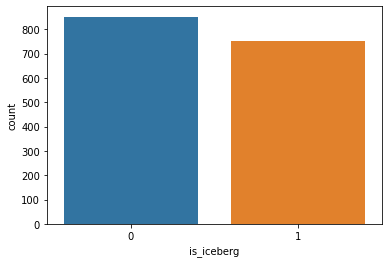

In [12]:
sns.countplot(train['is_iceberg']);

# Feature Engineering

In [13]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#np.concatenate해서 새로운 채널을 하나더 만들어주는 것이다 컬러이미지이기 때문에 
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [14]:
train.loc[14, 'is_iceberg']

0

In [15]:
#같은 14번 ship이지만 보는 각에 따라서 나오는 것이 다르다는 것을 보여주는 것 


band1 = X_band_1[14,:,:]
band2 = X_band_2[14,:,:]
#from plotly import tools, 이랗게 import tools를 하면 된다 
fig = tools.make_subplots(rows=1,cols=2, specs=[[{'is_3d': True}, {'is_3d':True}]])
data = go.Surface(z = band1, colorscale='aggrnyl', scene='scene1', showscale=True)
data1 = go.Surface(z = band2, colorscale='aggrnyl', scene='scene1', showscale=True)

fig['layout'].update(title='3D surface plot for "{}" ', titlefont=dict(size=30), height=800, width=1200)


fig.append_trace(data,1,1)
fig.append_trace(data1,1,2)
py.iplot(fig)

In [16]:
band1.shape

(75, 75)

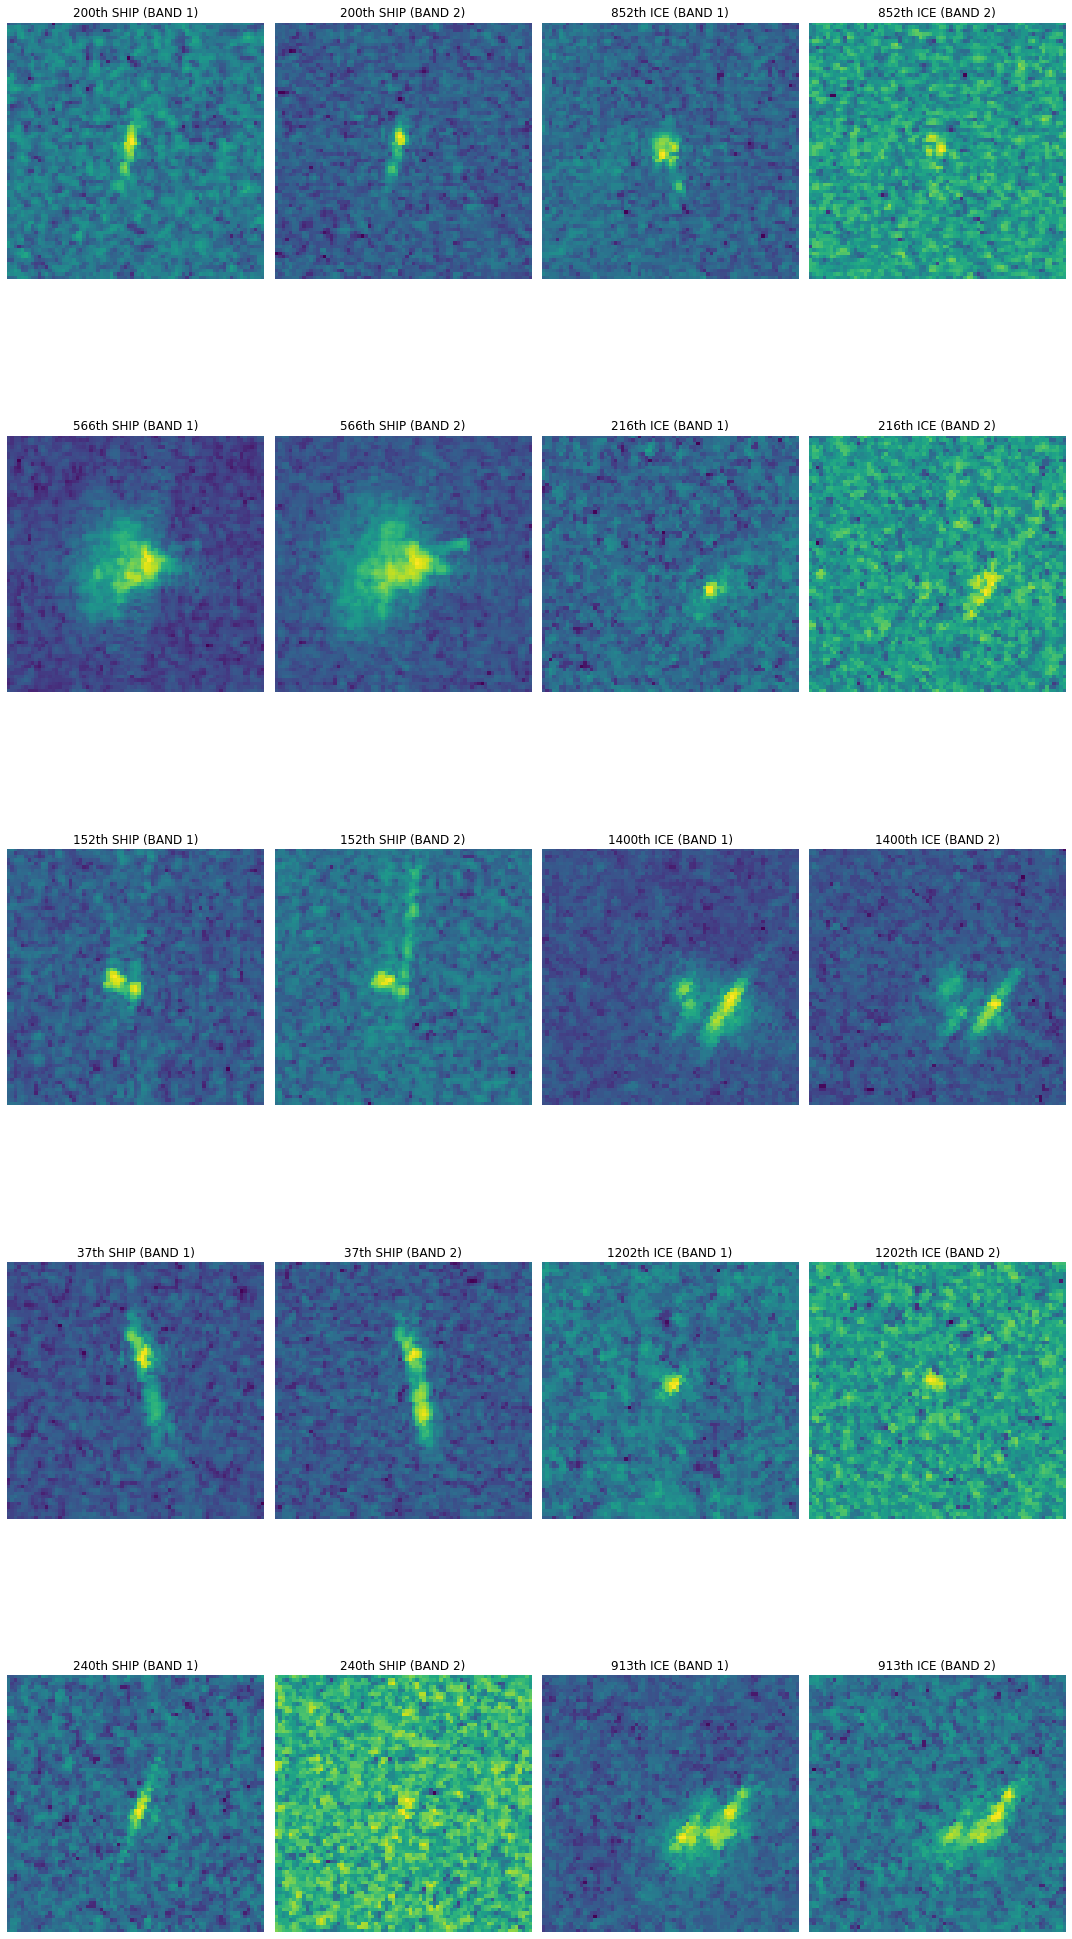

In [17]:
np.random.seed(42)

ship_index =  train[train['is_iceberg']==0].index.tolist()
ice_index = train[train['is_iceberg']==1].index.tolist()

rows = 5
cols = 4
i = 1

fig = plt.figure(figsize=(15,30)) 
for j in range(5) : 
    ship = np.random.choice(ship_index)
    ice = np.random.choice(ice_index)
    ship_band1 = X_band_1[ship,:,:]
    ship_band2 = X_band_2[ship,:,:]
    ice_band1 = X_band_1[ice,:,:]
    ice_band2 = X_band_2[ice,:,:]

    ax1 = fig.add_subplot(rows, cols, i)
    ax1.imshow(ship_band1)
    ax1.set_title(f'{ship}th SHIP (BAND 1)')
    ax1.axis("off")
    i+=1

    ax2 = fig.add_subplot(rows, cols, i)
    ax2.imshow(ship_band2)
    ax2.set_title(f'{ship}th SHIP (BAND 2)')
    ax2.axis("off")
    i+=1

    ax3 = fig.add_subplot(rows, cols, i)
    ax3.imshow(ice_band1)
    ax3.set_title(f'{ice}th ICE (BAND 1)')
    ax3.axis("off")
    i+=1

    ax4 = fig.add_subplot(rows, cols, i)
    ax4.imshow(ice_band2)
    ax4.set_title(f'{ice}th ICE (BAND 2)')
    ax4.axis("off")
    i+=1

fig.tight_layout()
plt.show()


---

# New Feature Engineering

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

In [19]:
def lee_filter(img, size):
    
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance**2 / (img_variance**2 + overall_variance**2)
    img_output = img_mean + img_weights * (img - img_mean)

    return img_output

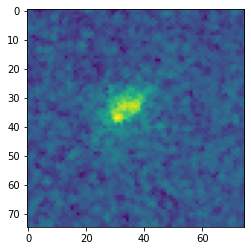

In [20]:
a = X_band_1[5,:,:]
plt.imshow(a)
plt.show()

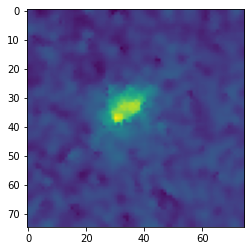

In [21]:
b = lee_filter(a,4)
plt.imshow(b)
plt.show()

In [22]:
def get_scaled_imgs(df):
    imgs = []
    # band1_list,band2_list,band3_list = [],[],[]
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        # band_3 = (band_1+band_2) / 2

        # use a lee filter to help with speckling
        band_1 = lee_filter(band_1,4)
        band_2 = lee_filter(band_2,4)
        band_3 = lee_filter(band_3,4)

        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))
        # imgs.append(np.dstack((band_1,band_2,band_3)))

    return np.array(imgs)

In [23]:
X = get_scaled_imgs(train)
X.shape

(1604, 75, 75, 3)

In [24]:
target_train = train['is_iceberg']

# Augmentation

In [25]:
import cv2

In [26]:
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    # hori_flip_imgs = []
    r1_imgs = []
    rr1_imgs = []
    rrr1_imgs =[]  
    r_imgs = []
    rr_imgs = []
    rrr_imgs =[]  

    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        ar1 = np.rot90(a)
        br1 = np.rot90(b)
        cr1 = np.rot90(c)

        arr1 = np.rot90(ar1)
        brr1 = np.rot90(br1)
        crr1 = np.rot90(cr1)

        arrr1 = np.rot90(arr1)
        brrr1 = np.rot90(brr1)
        crrr1 = np.rot90(crr1)

        av=cv2.flip(a,1)
        # ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        # bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        # ch=cv2.flip(c,0)

        ar = np.rot90(av)
        br = np.rot90(bv)
        cr = np.rot90(cv)

        arr = np.rot90(ar)
        brr = np.rot90(br)
        crr = np.rot90(cr)

        arrr = np.rot90(arr)
        brrr = np.rot90(brr)
        crrr = np.rot90(crr)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        # hori_flip_imgs.append(np.dstack((ah, bh, ch)))
        r1_imgs.append(np.dstack((ar1,br1,cr1)))
        rr1_imgs.append(np.dstack((arr1,brr1,crr1)))
        rrr1_imgs.append(np.dstack((arrr1,brrr1,crrr1)))
        r_imgs.append(np.dstack((ar,br,cr)))
        rr_imgs.append(np.dstack((arr,brr,crr)))
        rrr_imgs.append(np.dstack((arrr,brrr,crrr)))
      
    v = np.array(vert_flip_imgs)
    # h = np.array(hori_flip_imgs)
    r1 = np.array(r1_imgs)
    rr1 = np.array(rr1_imgs)
    rrr1 = np.array(rrr1_imgs)
    r = np.array(r_imgs)
    rr = np.array(rr_imgs)
    rrr = np.array(rrr_imgs)
       
    # more_images = np.concatenate((imgs,v,h))
    more_images = np.concatenate((imgs,v,r1,rr1,rrr1,r,rr,rrr))

    return more_images

In [27]:
X = get_more_images(X) 
target_train = np.concatenate((target_train,target_train,target_train,target_train,target_train,target_train,target_train,target_train))

In [28]:
X.shape

(12832, 75, 75, 3)

In [29]:
target_train.shape

(12832,)

# Modeling

In [30]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D,BatchNormalization
# from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [31]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    #Adam 은 모델을 최적화 시켜주는 기능을 한다, 
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [32]:

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      target_train,
                                                      random_state=42,
                                                      train_size = 0.8,
                                                      stratify=target_train)

In [33]:
#Without denoising, core features.
gmodel=getModel()
gmodel.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       1

In [34]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

81/81 [==============================] - 7s 88ms/step - loss: 0.2146 - accuracy: 0.9225
Test loss: 0.21463334560394287
Test accuracy: 0.9224776029586792


In [35]:
X_test = get_scaled_imgs(test)

In [36]:
predicted_test = gmodel.predict(X_test)
predicted_test

array([[0.03390634],
       [0.49940932],
       [0.28617555],
       ...,
       [0.06465548],
       [0.9998606 ],
       [0.7541044 ]], dtype=float32)

In [37]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('submission.csv', index=False)

In [38]:
# !kaggle competitions submit -c statoil-iceberg-classifier-challenge -f submission.csv -m "2021-08-26 first commit Sum_Channel+Lee_Filter+Augmentation+CNN"

# PseudoLabeling

In [39]:
X.shape

(12832, 75, 75, 3)

In [40]:
new_X = np.concatenate([X,X_test])
new_X.shape 

(21256, 75, 75, 3)

In [41]:
target_train.shape

(12832,)

In [42]:
target_train

array([0, 0, 1, ..., 0, 0, 0])

In [43]:
add_target = np.array([1 if i[0]>=0.5 else 0 for i in predicted_test])
new_y = np.concatenate([target_train,add_target])
new_y.shape

(21256,)

In [46]:

X_train, X_valid, y_train, y_valid = train_test_split(new_X,
                                                      new_y,
                                                      random_state=42,
                                                      train_size = 0.8,
                                                      stratify=new_y)

In [47]:
#Without denoising, core features.
gmodel=getModel()
gmodel.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)      

In [48]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

133/133 [==============================] - 12s 93ms/step - loss: 0.1978 - accuracy: 0.9219
Test loss: 0.197847381234169
Test accuracy: 0.9219191074371338


In [49]:
predicted_test = gmodel.predict(X_test)
predicted_test

array([[0.03144023],
       [0.9377569 ],
       [0.01334509],
       ...,
       [0.00804913],
       [0.99992573],
       [0.9932794 ]], dtype=float32)

In [50]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('submission.csv', index=False)

In [51]:
!kaggle competitions submit -c statoil-iceberg-classifier-challenge -f submission.csv -m "2021-08-26 second commit Sum_Channel+Lee_Filter+Augmentation+CNN+Pseudo_Labeling"

100% 168k/168k [00:00<00:00, 642kB/s]
Successfully submitted to Statoil/C-CORE Iceberg Classifier Challenge